# GPU programming using PyOpenCL, part 6: sort

This is a set of exercises on the usage of PyOpenCL. There are 6 main classes of parallel algorithms:
1. Map or Element-wise kernels: 1 thread calculates 1 result from 1 input position
2. Gather: 1 thread calculates 1 result from several input data, one typical example is the convolution
3. Scatter: 1 thread uses 1 input element and scatters it on one or several output pixels, this requires the usage of atomic operarions
4. Reduction: Apply the same associative operation on all element of an ensemble, for example the sum of all elements in a list.
5. Scan: also called *prefix sum*, this algorithm applies the same associative operation to all *previous* elements of a list, for example a cummulative sum (cumsum)
6. Sort: using sorting network like the bitonic sort.

This sixth  tutorial focuses on the **Bitonic sort** which is a net of parallel compare & exchange operation between 2 positions in and array and results in the sorted array.

The complexity of bitonic sort is $O(n\cdot log_2^2(n))$ with a delay of $O(log_2^2(n))$. It best works on a problem size power of two.

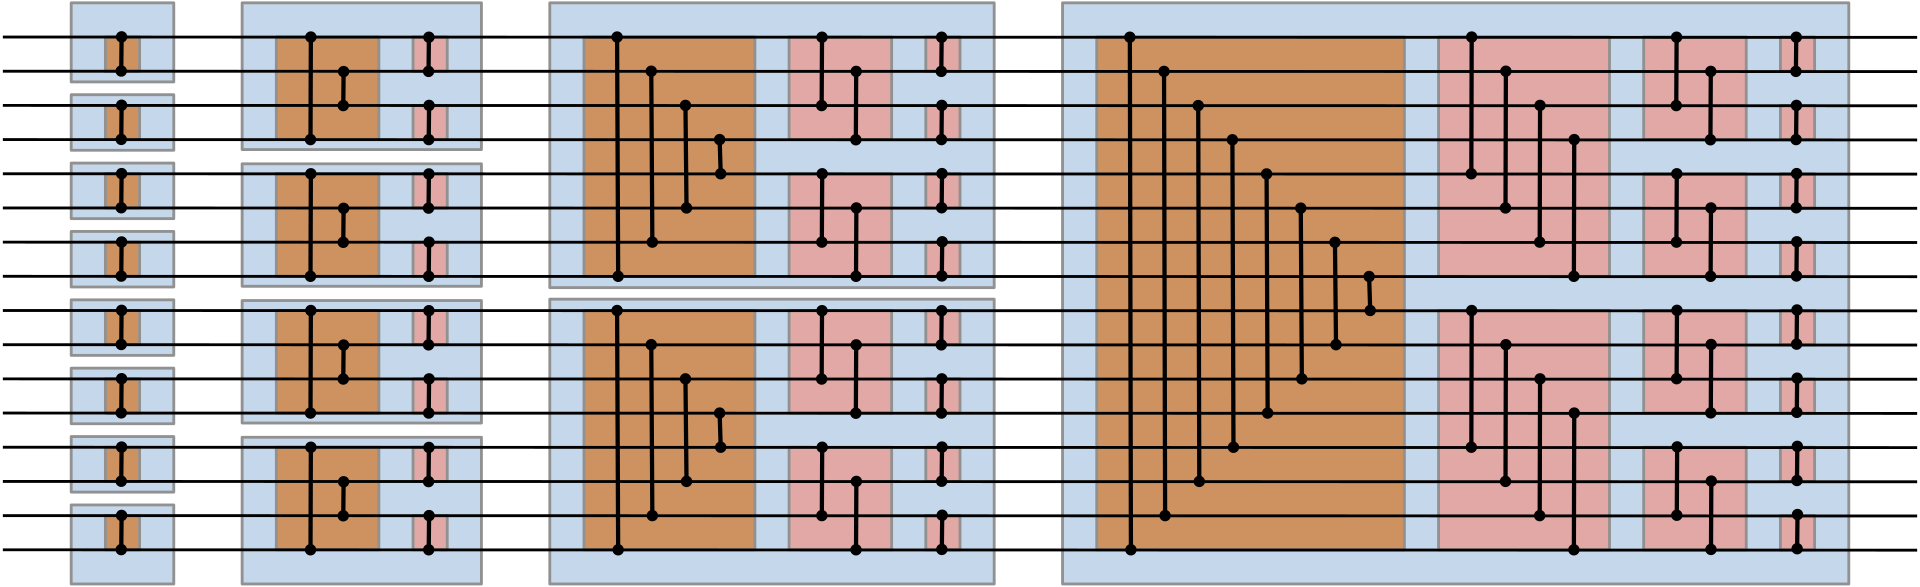

16 elements sorted, 26 cycles, 80 comparison & exchange

Implementing *bitonic nets* is complicated, metaprogramming helps really a lot here, let's see an example: 

In [ ]:
from math import ceil
import numpy as np
import pyopencl as cl
from pyopencl import array as cla
ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

size = 1<<24
ref = np.arange(size).astype("float32")

print(ctx.devices[0])

In [ ]:
from pyopencl.bitonic_sort import BitonicSort
bn = BitonicSort(ctx)

In [ ]:
a = ref.copy()
np.random.shuffle(a)
a_d = cla.to_device(queue, a)

res_d, evt = bn(a_d)
evt.wait()
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")
%timeit np.sort(a)
assert np.allclose(res_d.get(), ref)

## Now it is your turn: auto white balance

Images are stored in RGB format and sometimes one channel is too strong or two weak. The GIMP program implements an [auto white balance](https://docs.gimp.org/2.8/en/gimp-layer-white-balance.html) by measuring the black and white points at 0.05% and 99.95% of the pixel. It saturates 0.1% of pixel and equilibrate the color chanels this way.

Here is the procedure using numpy. Write the same procedure using OpenCL and the bitonic sort. Look at the performances.

In [ ]:
%matplotlib widget
from PIL import Image
from matplotlib.pyplot import subplots
filename = "14h33m35-SM-N970U1.jpg"
img = np.array(Image.open(filename)).astype("int32")
# unbalance color chanels ...
img[:,:,0] += 20
img[:,:,2] -= 20
img = np.clip(img, 0, 255).astype("uint8")

In [ ]:
%%time
R, G, B = img.reshape((-1,3)).T
Rs = np.sort(R)
Gs = np.sort(G)
Bs = np.sort(B)
R_min = Rs[int(len(R)*5e-4)]
G_min = Gs[int(len(R)*5e-4)]
B_min = Bs[int(len(R)*5e-4)]
R_max = Rs[int(len(R)*(1-5e-4))]
G_max = Gs[int(len(R)*(1-5e-4))]
B_max = Bs[int(len(R)*(1-5e-4))]
# img_awb = 
B_min, B_max
Rc = ((R-R_min)/(R_max-R_min)*255).clip(0, 255).astype("uint8")
Gc = ((G-G_min)/(G_max-G_min)*255).clip(0, 255).astype("uint8")
Bc = ((B-B_min)/(B_max-B_min)*255).clip(0, 255).astype("uint8")
img_awb = np.empty_like(img)
img_awb[...,0] = Rc.reshape(img.shape[:2])
img_awb[...,1] = Gc.reshape(img.shape[:2])
img_awb[...,2] = Bc.reshape(img.shape[:2])]

In [ ]:
fig, ax = subplots(1, 2, figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(img_awb)
ax[0].set_title("Before AWB")
ax[1].set_title("After AWB")
pass

In [ ]:
%load_ext pyopencl.ipython_ext

In [ ]:
%%cl_kernel
kernel void autowb(global uchar *rgb, global uchar *srt, 
                   int width, int height, int srt_size)
{
    int x,y;
    x = get_global_id(0);
    y = get_global_id(1);
    if ((x<width) && (y<height))
    {
        uchar r, g, b, rl, gl, bl, rh, gh, bh;
        int low, high;
        int i = (x + width * y);
        
        low  = convert_int_rtz(0.0005f*width*height);
        high = convert_int_rtp((1.0f-0.0005f)*width*height);
        
        r = rgb[3*i];
        g = rgb[3*i+1];
        b = rgb[3*i+2];

        rl = srt[low*3];
        gl = srt[low*3+1];
        bl = srt[low*3+2];
        
        rh = srt[high*3];
        gh = srt[high*3+1];        
        bh = srt[high*3+2];

        if ((x==5)&&(y==6)) printf("x:%d y:%d rgb: %u %u %u\n",x,y, rgb[3*i], rgb[3*i+1], rgb[3*i+2]);

        rgb[3*i]   = (uchar) (255.0f * clamp(((float)r-rl)/(rh-rl), 0.0f, 1.0f));
        rgb[3*i+1] = (uchar) (255.0f * clamp(((float)g-gl)/(gh-gl), 0.0f, 1.0f));
        rgb[3*i+2] = (uchar) (255.0f * clamp(((float)b-bl)/(bh-bl), 0.0f, 1.0f));
        if ((x==5)&&(y==6)) printf("x:%d y:%d rgb: %u %u %u\n",x,y, rgb[3*i], rgb[3*i+1], rgb[3*i+2]);
    }
}

In [ ]:
# %%timeit 
img_d = cla.to_device(queue, img)
unpadded = np.prod(img.shape[:2])
padded = 1<<int(ceil(np.log2(unpadded)))
rgb_d = cla.empty(queue, (padded,3), "uint8")
rgb_d.fill(255)
rgb_d[:unpadded, :] = img.reshape(-1, 3)
bn = BitonicSort(ctx)
sort_d, evt = bn(rgb_d)
evt.wait()
print(f"Profile time, sort: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")
evt = autowb(queue, img.shape[1::-1], (128,1),
       img_d.data, rgb_d.data,
       np.int32(img.shape[1]), np.int32(img.shape[0]), np.int32(padded))
evt.wait()
print(f"Profile time, map: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")

In [ ]:
fig, ax = subplots(1, 2, figsize=(10,5))
ax[0].imshow(img)
ax[0].set_title("Before AWB")
ax[1].imshow(img_d.get())
ax[1].set_title("After AWB")
pass